In [1]:
from yolov5_utils.utils.datasets import *

In [47]:
from yolov5_utils.utils.general import colorstr

In [2]:
label_dir="/media/asad/ADAS_CV/datasets_Vegs/tomatoes/dataset_v4/tomatoes_dataset_yolo/train_tomatoe_small.txt"

In [3]:
#dataset

In [4]:
class LoadImagesAndLabels2(Dataset):  # for training/testing
    def __init__(self, path, img_size=640, batch_size=16, augment=False, hyp=None, rect=False, image_weights=False,
                 cache_images=False, single_cls=False, stride=32, pad=0.0, prefix=''):
        self.img_size = img_size
        self.augment = augment
        self.hyp = hyp
        self.image_weights = image_weights
        self.rect = False if image_weights else rect
        self.mosaic = self.augment and not self.rect  # load 4 images at a time into a mosaic (only during training)
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.stride = stride
        self.path = path
        self.albumentations = Albumentations() if augment else None

        try:
            f = []  # image files
            for p in path if isinstance(path, list) else [path]:
                p = Path(p)  # os-agnostic
                if p.is_dir():  # dir
                    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
                    # f = list(p.rglob('**/*.*'))  # pathlib
                elif p.is_file():  # file
                    with open(p, 'r') as t:
                        t = t.read().strip().splitlines()
                        parent = str(p.parent) + os.sep
                        f += [x.replace('./', parent) if x.startswith('./') else x for x in t]  # local to global path
                        # f += [p.parent / x.lstrip(os.sep) for x in t]  # local to global path (pathlib)
                else:
                    raise Exception(f'{prefix}{p} does not exist')
            self.img_files = sorted([x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in IMG_FORMATS])
            # self.img_files = sorted([x for x in f if x.suffix[1:].lower() in img_formats])  # pathlib
            assert self.img_files, f'{prefix}No images found'
        except Exception as e:
            raise Exception(f'{prefix}Error loading data from {path}: {e}\nSee {HELP_URL}')

        # Check cache
        self.label_files = img2label_paths(self.img_files)  # labels
        cache_path = (p if p.is_file() else Path(self.label_files[0]).parent).with_suffix('.cache')
        try:
            cache, exists = np.load(cache_path, allow_pickle=True).item(), True  # load dict
            assert cache['version'] == 0.4 and cache['hash'] == get_hash(self.label_files + self.img_files)
        except:
            cache, exists = self.cache_labels(cache_path, prefix), False  # cache

        # Display cache
        nf, nm, ne, nc, n = cache.pop('results')  # found, missing, empty, corrupted, total
        if exists:
            d = f"Scanning '{cache_path}' images and labels... {nf} found, {nm} missing, {ne} empty, {nc} corrupted"
            tqdm(None, desc=prefix + d, total=n, initial=n)  # display cache results
            if cache['msgs']:
                logging.info('\n'.join(cache['msgs']))  # display warnings
        assert nf > 0 or not augment, f'{prefix}No labels in {cache_path}. Can not train without labels. See {HELP_URL}'

        # Read cache
        [cache.pop(k) for k in ('hash', 'version', 'msgs')]  # remove items
        labels, shapes, self.segments = zip(*cache.values())
        self.labels = list(labels)
        self.shapes = np.array(shapes, dtype=np.float64)
        self.img_files = list(cache.keys())  # update
        self.label_files = img2label_paths(cache.keys())  # update
        if single_cls:
            for x in self.labels:
                x[:, 0] = 0

        n = len(shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(np.int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.indices = range(n)
        print(f"Labels are {self.labels}")
        print(f"Shapes are {self.shapes}")
        print(f"Rect is {self.rect}")

        # Rectangular Training
        if self.rect:
            # Sort by aspect ratio
            s = self.shapes  # wh
            ar = s[:, 1] / s[:, 0]  # aspect ratio
            irect = ar.argsort()
            self.img_files = [self.img_files[i] for i in irect]
            self.label_files = [self.label_files[i] for i in irect]
            self.labels = [self.labels[i] for i in irect]
            self.shapes = s[irect]  # wh
            ar = ar[irect]

            # Set training image shapes
            shapes = [[1, 1]] * nb
            for i in range(nb):
                ari = ar[bi == i]
                mini, maxi = ari.min(), ari.max()
                if maxi < 1:
                    shapes[i] = [maxi, 1]
                elif mini > 1:
                    shapes[i] = [1, 1 / mini]

            self.batch_shapes = np.ceil(np.array(shapes) * img_size / stride + pad).astype(np.int) * stride

        # Cache images into memory for faster training (WARNING: large datasets may exceed system RAM)
        self.imgs, self.img_npy = [None] * n, [None] * n
        if cache_images:
            if cache_images == 'disk':
                self.im_cache_dir = Path(Path(self.img_files[0]).parent.as_posix() + '_npy')
                self.img_npy = [self.im_cache_dir / Path(f).with_suffix('.npy').name for f in self.img_files]
                self.im_cache_dir.mkdir(parents=True, exist_ok=True)
            gb = 0  # Gigabytes of cached images
            self.img_hw0, self.img_hw = [None] * n, [None] * n
            results = ThreadPool(NUM_THREADS).imap(lambda x: load_image(*x), zip(repeat(self), range(n)))
            pbar = tqdm(enumerate(results), total=n)
            for i, x in pbar:
                if cache_images == 'disk':
                    if not self.img_npy[i].exists():
                        np.save(self.img_npy[i].as_posix(), x[0])
                    gb += self.img_npy[i].stat().st_size
                else:
                    self.imgs[i], self.img_hw0[i], self.img_hw[i] = x  # im, hw_orig, hw_resized = load_image(self, i)
                    gb += self.imgs[i].nbytes
                pbar.desc = f'{prefix}Caching images ({gb / 1E9:.1f}GB {cache_images})'
            pbar.close()

    def cache_labels(self, path=Path('./labels.cache'), prefix=''):
        # Cache dataset labels, check images and read shapes
        x = {}  # dict
        nm, nf, ne, nc, msgs = 0, 0, 0, 0, []  # number missing, found, empty, corrupt, messages
        desc = f"{prefix}Scanning '{path.parent / path.stem}' images and labels..."
        with Pool(NUM_THREADS) as pool:
            pbar = tqdm(pool.imap_unordered(verify_image_label, zip(self.img_files, self.label_files, repeat(prefix))),
                        desc=desc, total=len(self.img_files))
            for im_file, l, shape, segments, nm_f, nf_f, ne_f, nc_f, msg in pbar:
                nm += nm_f
                nf += nf_f
                ne += ne_f
                nc += nc_f
                if im_file:
                    x[im_file] = [l, shape, segments]
                if msg:
                    msgs.append(msg)
                pbar.desc = f"{desc}{nf} found, {nm} missing, {ne} empty, {nc} corrupted"

        pbar.close()
        if msgs:
            logging.info('\n'.join(msgs))
        if nf == 0:
            logging.info(f'{prefix}WARNING: No labels found in {path}. See {HELP_URL}')
        x['hash'] = get_hash(self.label_files + self.img_files)
        x['results'] = nf, nm, ne, nc, len(self.img_files)
        x['msgs'] = msgs  # warnings
        x['version'] = 0.4  # cache version
        try:
            np.save(path, x)  # save cache for next time
            path.with_suffix('.cache.npy').rename(path)  # remove .npy suffix
            logging.info(f'{prefix}New cache created: {path}')
        except Exception as e:
            logging.info(f'{prefix}WARNING: Cache directory {path.parent} is not writeable: {e}')  # path not writeable
        return x

    def __len__(self):
        return len(self.img_files)

    # def __iter__(self):
    #     self.count = -1
    #     print('ran dataset iter')
    #     #self.shuffled_vector = np.random.permutation(self.nF) if self.augment else np.arange(self.nF)
    #     return self

    def __getitem__(self, index):
        index = self.indices[index]  # linear, shuffled, or image_weights

        hyp = self.hyp
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        if mosaic:
            # Load mosaic
            img, labels = load_mosaic(self, index)
            shapes = None

            # MixUp augmentation
            if random.random() < hyp['mixup']:
                img, labels = mixup(img, labels, *load_mosaic(self, random.randint(0, self.n - 1)))

        else:
            # Load image
            img, (h0, w0), (h, w) = load_image(self, index)

            # Letterbox
            shape = self.batch_shapes[self.batch[index]] if self.rect else self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            labels = self.labels[index].copy()
            if labels.size:  # normalized xywh to pixel xyxy format
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1])

            if self.augment:
                img, labels = random_perspective(img, labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])

        nl = len(labels)  # number of labels
        if nl:
            labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=img.shape[1], h=img.shape[0], clip=True, eps=1E-3)

        if self.augment:
            # Albumentations
            img, labels = self.albumentations(img, labels)
            nl = len(labels) # update after albumentations

            # HSV color-space
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

            # Flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nl:
                    labels[:, 2] = 1 - labels[:, 2]

            # Flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nl:
                    labels[:, 1] = 1 - labels[:, 1]

            # Cutouts
            # labels = cutout(img, labels, p=0.5)

        labels_out = torch.zeros((nl, 6))
        if nl:
            labels_out[:, 1:] = torch.from_numpy(labels)

        # Convert
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        return torch.from_numpy(img), labels_out, self.img_files[index], shapes


In [5]:
dataset = LoadImagesAndLabels2(label_dir, augment=True, rect=True)

Scanning '/media/asad/ADAS_CV/datasets_Vegs/tomatoes/dataset_v4/tomatoes_dataset_yolo/train_tomatoe_small.cache' images and labels... 18 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 18/18 [00:00<?, ?it/s]

Labels are [array([[          0,        0.26,        0.87,       0.184,         0.2],
       [          0,       0.283,       0.695,       0.194,        0.18],
       [          0,       0.265,       0.535,        0.19,       0.235],
       [          0,       0.091,       0.734,       0.178,       0.217],
       [          0,        0.07,       0.562,       0.136,       0.235],
       [          0,       0.068,       0.349,       0.132,       0.212]], dtype=float32), array([[          0,       0.955,       0.946,       0.082,       0.098],
       [          0,       0.988,        0.85,       0.024,        0.11],
       [          0,       0.939,       0.836,       0.066,       0.092],
       [          0,       0.558,       0.956,       0.044,       0.048],
       [          0,       0.559,       0.899,       0.046,       0.052],
       [          0,       0.545,       0.772,       0.042,       0.055],
       [          0,       0.548,       0.826,       0.048,       0.058],
       [ 

In [67]:
def kmean_anchors(dataset='./data/coco128.yaml', n=9, img_size=640, thr=4.0, gen=1000, verbose=True,plot=True):
    """ Creates kmeans-evolved anchors from training dataset

        Arguments:
            dataset: path to data.yaml, or a loaded dataset
            n: number of anchors
            img_size: image size used for training
            thr: anchor-label wh ratio threshold hyperparameter hyp['anchor_t'] used for training, default=4.0
            gen: generations to evolve anchors using genetic algorithm
            verbose: print all results

        Return:
            k: kmeans evolved anchors

        Usage:
            from utils.autoanchor import *; _ = kmean_anchors()
    """
    from scipy.cluster.vq import kmeans

    thr = 1. / thr
    prefix = colorstr('autoanchor: ')

    def metric(k, wh):  # compute metrics
        r = wh[:, None] / k[None]
        x = torch.min(r, 1. / r).min(2)[0]  # ratio metric
        # x = wh_iou(wh, torch.tensor(k))  # iou metric
        return x, x.max(1)[0]  # x, best_x

    def anchor_fitness(k):  # mutation fitness
        _, best = metric(torch.tensor(k, dtype=torch.float32), wh)
        return (best * (best > thr).float()).mean()  # fitness

    def print_results(k):
        k = k[np.argsort(k.prod(1))]  # sort small to large
        x, best = metric(k, wh0)
        bpr, aat = (best > thr).float().mean(), (x > thr).float().mean() * n  # best possible recall, anch > thr
        print(f'{prefix}thr={thr:.2f}: {bpr:.4f} best possible recall, {aat:.2f} anchors past thr')
        print(f'{prefix}n={n}, img_size={img_size}, metric_all={x.mean():.3f}/{best.mean():.3f}-mean/best, '
              f'past_thr={x[x > thr].mean():.3f}-mean: ', end='')
        for i, x in enumerate(k):
            print('%i,%i' % (round(x[0]), round(x[1])), end=',  ' if i < len(k) - 1 else '\n')  # use in *.cfg
        return k

    if isinstance(dataset, str):  # *.yaml file
        with open(dataset, errors='ignore') as f:
            data_dict = yaml.safe_load(f)  # model dict
        from utils.datasets import LoadImagesAndLabels
        dataset = LoadImagesAndLabels(data_dict['train'], augment=True, rect=True)

    # Get label wh
    #shapes = img_size * dataset.shapes / dataset.shapes.max(1, keepdims=True)
    shapes=dataset.shapes
    wh0 = np.concatenate([l[:, 3:5] * s for s, l in zip(shapes, dataset.labels)])  # wh

    # Filter
    i = (wh0 < 3.0).any(1).sum()
    if i:
        print(f'{prefix}WARNING: Extremely small objects found. {i} of {len(wh0)} labels are < 3 pixels in size.')
    wh = wh0[(wh0 >= 2.0).any(1)]  # filter > 2 pixels
    # wh = wh * (np.random.rand(wh.shape[0], 1) * 0.9 + 0.1)  # multiply by random scale 0-1

    # Kmeans calculation
    print(f'{prefix}Running kmeans for {n} anchors on {len(wh)} points...')
    s = wh.std(0)  # sigmas for whitening
    k, dist = kmeans(wh / s, n, iter=30)  # points, mean distance
    assert len(k) == n, print(f'{prefix}ERROR: scipy.cluster.vq.kmeans requested {n} points but returned only {len(k)}')
    k *= s
    wh = torch.tensor(wh, dtype=torch.float32)  # filtered
    wh0 = torch.tensor(wh0, dtype=torch.float32)  # unfiltered
    k = print_results(k)
    
    print(f"Results before Evloution {k}")

    # Plot
    # k, d = [None] * 20, [None] * 20
    # for i in tqdm(range(1, 21)):
    #     k[i-1], d[i-1] = kmeans(wh / s, i)  # points, mean distance
    # fig, ax = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)
    # ax = ax.ravel()
    # ax[0].plot(np.arange(1, 21), np.array(d) ** 2, marker='.')
    # fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # plot wh
    # ax[0].hist(wh[wh[:, 0]<100, 0],400)
    # ax[1].hist(wh[wh[:, 1]<100, 1],400)
    # fig.savefig('wh.png', dpi=200)

    # Evolve
    npr = np.random
    f, sh, mp, s = anchor_fitness(k), k.shape, 0.9, 0.1  # fitness, generations, mutation prob, sigma
    pbar = tqdm(range(gen), desc=f'{prefix}Evolving anchors with Genetic Algorithm:')  # progress bar
    for _ in pbar:
        v = np.ones(sh)
        while (v == 1).all():  # mutate until a change occurs (prevent duplicates)
            v = ((npr.random(sh) < mp) * random.random() * npr.randn(*sh) * s + 1).clip(0.3, 3.0)
        kg = (k.copy() * v).clip(min=2.0)
        fg = anchor_fitness(kg)
        if fg > f:
            f, k = fg, kg.copy()
            pbar.desc = f'{prefix}Evolving anchors with Genetic Algorithm: fitness = {f:.4f}'
            if verbose:
                print_results(k)
    if plot:
        whpl=wh.cpu().numpy()
        plt.scatter(whpl[:, 0], whpl[:, 1])
        plt.scatter(k[:, 0], k[:, 1], c='r')
        plt.xlabel("Widths")
        plt.ylabel("Heights")
    
    return print_results(k)

autoanchor: Running kmeans for 3 anchors on 145 points...
autoanchor: thr=0.25: 1.0000 best possible recall, 2.21 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.472/0.738-mean/best, past_thr=0.573-mean: 37,36,  109,100,  181,187
Results before Evloution [[     37.026      36.246]
 [     108.58      100.39]
 [     181.43      186.74]]


autoanchor: Evolving anchors with Genetic Algorithm: fitness = 0.7537:  21%|██        | 210/1000 [00:00<00:00, 2096.90it/s]

autoanchor: thr=0.25: 1.0000 best possible recall, 2.21 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.473/0.738-mean/best, past_thr=0.574-mean: 37,36,  108,101,  179,186
autoanchor: thr=0.25: 1.0000 best possible recall, 2.20 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.472/0.739-mean/best, past_thr=0.576-mean: 36,37,  108,100,  179,186
autoanchor: thr=0.25: 1.0000 best possible recall, 2.19 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.473/0.740-mean/best, past_thr=0.579-mean: 37,36,  107,100,  177,183
autoanchor: thr=0.25: 1.0000 best possible recall, 2.19 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.472/0.741-mean/best, past_thr=0.578-mean: 35,36,  107,100,  177,183
autoanchor: thr=0.25: 1.0000 best possible recall, 2.19 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.473/0.741-mean/best, past_thr=0.579-mean: 36,36,  108,101,  178,181
autoanchor: thr=0.25: 1.0000 best possible recall, 2.20 anchors past thr
au

autoanchor: Evolving anchors with Genetic Algorithm: fitness = 0.7547: 100%|██████████| 1000/1000 [00:00<00:00, 3375.69it/s]


autoanchor: thr=0.25: 1.0000 best possible recall, 2.26 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.479/0.755-mean/best, past_thr=0.575-mean: 34,35,  93,88,  165,159
autoanchor: thr=0.25: 1.0000 best possible recall, 2.26 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.479/0.755-mean/best, past_thr=0.575-mean: 34,35,  93,88,  165,159
autoanchor: thr=0.25: 1.0000 best possible recall, 2.26 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.479/0.755-mean/best, past_thr=0.575-mean: 34,35,  93,88,  165,159
autoanchor: thr=0.25: 1.0000 best possible recall, 2.26 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.479/0.755-mean/best, past_thr=0.575-mean: 34,35,  93,88,  165,159
autoanchor: thr=0.25: 1.0000 best possible recall, 2.26 anchors past thr
autoanchor: n=3, img_size=640, metric_all=0.479/0.755-mean/best, past_thr=0.575-mean: 34,35,  93,88,  165,159
autoanchor: thr=0.25: 1.0000 best possible recall, 2.24 anchors past thr
autoanchor: 

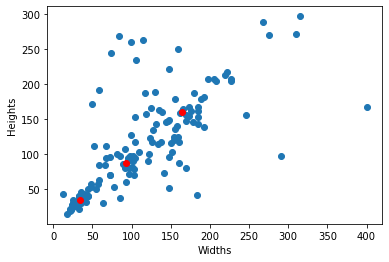

In [68]:
k=kmean_anchors(dataset,n=3)

In [69]:
k[:,1]/k[:,0]

array([     1.0302,     0.94861,     0.97167])